# Lesson 10

## 00:00:14 - Review of last week

* Last week: lots of people struggling with the material from last week.
  * By Lesson 14, you'll have a second go at Object Detection.
* Multiple objects is similar to the single bounding box problem, except we have to solve the "matching problems"
  * Create far more activations than ground truth bounding boxes, and match each ground truth object to a set of the activations.
* If you're stuck: revisit Lesson 8.
  
## 00:02:42 - Multiple objects revision

* More activations.
* Took advantage of convolutional natural of network to try to have activiations that had a receptive field that was similar to ground truth objects we're predicting.
  * [Chloe Sultan](http://forums.fast.ai/t/part-2-lesson-9-wiki/14028/375) mapped out the size of the grids as the network downsamples using stride 2 convolutions.
  
<img src="http://forums.fast.ai/uploads/default/optimized/2X/a/a7942de9d5bf6c3afe50e10d55116c6c7fb5b721_1_669x500.png" width="700px">

* How did she calculate the numbers?
  * Could use PDB set trace to view the output at each step of the network.
* Talked about increasing K: number of activations using different zooms and sizes.
* Got down to a small num of bounding boxes using NMS.
  * A paper has come out to try to calculate an end-to-end network (not using NMS)


## 00:07:04 - Reading papers

* Not enough people reading papers in study group: papers are the "real ground truth".
  * ``SSD_MultiHead.forward`` is not doing the same thing as the SSD paper: the paper may have a better version.
  * Uses a smaller k but a lot more smaller grids.
* Useful to map code and equations together:

<img src="https://i.gyazo.com/84dc304d3d8eab72b6fcbc1895424aa5.gif" width="700px">

  * Some people are code people who learn the math from the code and vice versa.
  
## 00:10:08 - Math notation

* Math notation can be hard to lookup.
* [List of mathematical symbols](https://en.wikipedia.org/wiki/List_of_mathematical_symbols) Wikipedia article is a useful reference.
* Nobody learns all of math in one go: even top researchers need to research math symbols.

## 00:11:17 - Recreating results in papers

* Key figure from retina loss figure was created in Excel by Sarada Lee from the forums.


## 00:14:12 - NLP

* Seen the idea of taking a pretrained model, removing the top layer and getting it to do something similar.
 * Want to see if that idea applies to NLP.
* Next lesson: combine NLP and computer vision.
  * learn to find word structures from images (image captioning)
  * learn to find images from word structures

## 00:18:56 - torchtext to fastai.text

* torchtext has a number of limitations:
  * quite slow
    * doesn't do parallel processing.
    * doesn't cache results.
  * hard to do simple things like multi label problems.
* `fastai.text` is a replacement for `fastai.nlp`

## 00:20:30 - IMDB revisited

* Dataset of movie reviews.

In [1]:
from fastai.text import *
import html
from pathlib import Path

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
PATH = Path('./data/aclImdb/')

### ** Start do not rerun **

In [76]:
!python -m spacy download en

    100% |████████████████████████████████| 37.4MB 606kB/s ta 0:00:0111
  Running setup.py install for en-core-web-sm ... done

    Linking successful
    /home/lex/anaconda3/envs/fastai/lib/python3.6/site-packages/en_core_web_sm
    -->
    /home/lex/anaconda3/envs/fastai/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [4]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz  --directory-prefix=data

--2018-07-28 17:09:05--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: 'data/aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  1.46MB/s    in 67s     

2018-07-28 17:10:13 (1.20 MB/s) - 'data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [6]:
!tar -xzf data/aclImdb_v1.tar.gz -C data

### ** End do not rerun **

In [4]:
BEGINNING_OF_SENTENCE_TAG = 'xbos'  # beginning of sentence tag
DATAFIELD_TAG = 'xfld'  # data field tag

CLAS_PATH = Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

CLASSES = ['neg', 'pos', 'unsup']

### ** Start do not rerun **

### 00:21:27 - Preparing data for language model and classification model

* Basic path of NLP: convert sentences into numbers.
* ``fastai.text`` doesn't many helper functions: gives you more flexibility.

* Data set has 3 classes:
  * negative
  * positive
  * unsup (unsupervised - aka unlabelled)

In [5]:
def get_texts(path):
    texts, labels = [], []
    for idx, label in enumerate(CLASSES):
        for fname in (path / label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)

    return np.array(texts), np.array(labels)
            
train_texts, train_labels = get_texts(PATH / 'train')
val_texts, val_labels = get_texts(PATH / 'test')

In [6]:
len(train_texts), len(val_texts)

(75000, 25000)

* Approach above is much easier than the convoluted torch text method - reading text is not that hard.

In [7]:
col_names = ['labels', 'text']

In [8]:
np.random.seed(42)

train_idx = np.random.permutation(len(train_texts))
val_idx = np.random.permutation(len(val_texts))

In [11]:
train_texts = train_texts[train_idx]
val_texts = val_texts[val_idx]

In [12]:
train_texts.shape

(75000,)

In [13]:
train_texts[0]

'A Paul Naschy vehicle in which he plays an East Indian guru named (what else?) Krishna who may or may not be responsible for gang of murderous zombies on the loose in London, but the real \'stars\' of this flick are the unintentional humor and the relentlessly kitschy soundtrack (the end title theme is particularly memorable, in that "so bad, it\'s good" category). Other things to watch out for include the stock footage of London, grinning zombies, a blinking corpse, and an "out of left field" plot twist. Stupendously bad, but terrific fun for those into this sort of thing.'

### 00:25:50 - Classification path vs language model path

* Classification model requires labels.

In [14]:
df_train = pd.DataFrame({'text': train_texts, 'labels': train_labels}, columns=col_names)
df_val = pd.DataFrame({'text': val_texts, 'labels': val_labels}, columns=col_names)

* 00:26:31: For the classification model, we remove all labels with a category of 2 which represents unsupervised.

In [15]:
df_train[df_train['labels'] != 2].to_csv(CLAS_PATH / 'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH / 'test.csv', header=False, index=False)

(CLAS_PATH / 'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

df_train.head()

,labels,text
0,0,A Paul Naschy vehicle in which he plays an Eas...
1,0,There's really no way to beat around the bush ...
2,0,I went to see Hamlet because I was in between ...
3,0,This 'remake' of Lars Von Trier's series does ...
4,0,This movie is worse than Disaster Movie a wort...


* For the language model, we can create our own validation set by concatting the original train / val, then taking a random 90/10 split:

In [16]:
train_texts, val_texts = sklearn.model_selection.train_test_split(np.concatenate([train_texts, val_texts]), test_size=0.1)

In [17]:
len(train_texts), len(val_texts)

(90000, 10000)

* Language model has no labels so we just use 0s (allowing for a consistent format):

In [18]:
df_train = pd.DataFrame({'text': train_texts, 'labels': [0] * len(train_texts)}, columns=col_names)
df_val = pd.DataFrame({'text': val_texts, 'labels': [0] * len(val_texts)}, columns=col_names)

df_train.to_csv(LM_PATH / 'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH / 'test.csv', header=False, index=False)

### 00:28:02 - Tokenisation

* Convert document to a list of tokens: like a list of words but with more tokens.
  * Spacy does the heavy lifting for tokenisation.
* Before passing to Spacy, we do some cleaning, which is based on what Jeremy has seen so far:

In [19]:
chunk_size = 24000

In [20]:
re1 = re.compile(r' +')

def fixup(x):
    x = (x
        .replace('#39;', "'")
        .replace('amp;', '&')
        .replace('#146;', "'")
        .replace('nbsp;', ' ')
        .replace('#36;', '$')
        .replace('\\n', "\n")
        .replace('quot;', "'")
        .replace('<br />', "\n")
        .replace('\\"', '"')
        .replace('<unk>', 'u_n')
        .replace(' @.@ ', '.')
        .replace(' @-@ ', '-')
        .replace('\\', ' \\ '))

    return re1.sub(' ', html.unescape(x))

* 00:29:40 - We then call `get_all` which calls `get_texts` which applies fixup amongst other things.
  * ``get_texts``: converts labels to ints.
    * Adds `beginning of sentence tags`
    * Adds `datafield_tag` that let's you have different types of fields (like title, body etc)
  * ``
  * ``Tokenizer().proc_all_mp`` - uses multi processing to tokenize, which Spacy doesn't do that well by default.

In [21]:
def get_texts(df, num_labels=1):
    labels = df.iloc[:, range(num_labels)].values.astype(np.int64)
    texts = f'\n{BEGINNING_OF_SENTENCE_TAG} {DATAFIELD_TAG} 1' + df[num_labels].astype(str)
    for i in range(num_labels + 1, len(df.columns)):
        texts += f' {DATAFIELD_TAG} [i - num_labels]' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    
    core_partitions = partition_by_cores(texts)
    tok = Tokenizer().proc_all_mp(core_partitions)
    return tok, list(labels)

In [22]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

* We pass in an addition arg to Pandas called `chunksize` which lets us work on a bit at a time.

In [23]:
df_train = pd.read_csv(LM_PATH / 'train.csv', header=None, chunksize=chunk_size)
df_val = pd.read_csv(LM_PATH / 'test.csv', header=None, chunksize=chunk_size)

### 00:31:31 - Audience questions

* Q1: Should I discard foreign text characters?
* A1: Keep them. Let the data tell you what characters matter.

* Tradition ML: lemmatisation and normalisation
  * Throwing away information that could be useful.

In [24]:
tok_trn, train_labels = get_all(df_train, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [25]:
(LM_PATH / 'tmp').mkdir(exist_ok=True)

In [26]:
np.save(LM_PATH / 'tmp'/ 'tok_trn.npy', tok_trn)
np.save(LM_PATH / 'tmp'/ 'tok_val.npy', tok_val)

### ** End do not rerun **

### 00:35:40 - Examining tokenisation

In [27]:
tok_trn = np.load(LM_PATH / 'tmp' / 'tok_trn.npy')
tok_val = np.load(LM_PATH / 'tmp' / 'tok_val.npy')

In [28]:
' '.join(tok_trn[0])

"\n xbos xfld 1like classic hollywood musicals , the plot is just an excuse . a must see for those interested in french music hall ( including a song by édith piaf ) and for the wonderful 10 plus minute cancan finale . the dancing in the film is not at all like what usually passes for cancan . \n\n some might object to the technicolor costumes and the bright lighting , but it gives you a clear view of some grand costumes and sets . \n\n consider it jean renoir 's love letter to the paris he grew up in . certainly the jean renoir film for people who do n't like his serious films or who only like his hollywood productions . \n\n"

* `t_up` will note that the following characters were uppercase.
  * Allows for using the same token but not loosing information encoded in casing: "screw you" vs "SCREW YOU"

### 00:38:08 - Numericalising

* Make a list of all words in order and use the index of the word at that point.

In [29]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1202538),
 ('.', 991832),
 (',', 985363),
 ('and', 587739),
 ('a', 580733),
 ('of', 524290),
 ('to', 484158),
 ('is', 393516),
 ('it', 339202),
 ('in', 337431),
 ('i', 288859),
 ('that', 260975),
 ('this', 257489),
 ('"', 235112),
 ("'s", 221356),
 ('-', 187623),
 ('was', 180076),
 ('\n\n', 179206),
 ('as', 164825),
 ('with', 159002),
 ('for', 158231),
 ('movie', 157585),
 ('but', 149963),
 ('film', 143691),
 ('you', 123786)]

* We limit the vocab to the top 60000 words, with a min frequency of twice.

In [30]:
max_vocab = 60000
min_freq = 2

In [31]:
itos = [o for o, c in freq.most_common(max_vocab) if c > min_freq]

* Also want to add tokens for unknown and padding.

In [32]:
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [33]:
itos[:10]

['_unk_', '_pad_', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is']

In [34]:
itos[-10:]

['cabel',
 'murph',
 'mousette',
 'bonifant',
 'jessy',
 'griffins',
 'shiraishi',
 'prefecture',
 'eriko',
 'haruhiko']

* Create a string to id dictionary:

In [35]:
stoi = collections.defaultdict(lambda: 0, {v: k for k, v in enumerate(itos)})

In [36]:
len(itos), len(stoi)

(60002, 60002)

Can now call that for every word in every sentence to get an array of numbers:

In [37]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [38]:
' '.join(str(o) for o in trn_lm[0])

'39 40 41 5982 393 364 3716 4 2 128 9 55 46 1417 3 6 226 82 22 162 926 11 712 239 2304 30 597 6 654 45 0 26402 27 5 22 2 423 180 897 879 20401 2024 3 2 1250 11 2 25 9 32 43 42 51 62 650 3919 22 20401 3 19 63 254 3206 8 2 5245 1360 5 2 1881 1548 4 24 10 424 26 6 747 666 7 63 1696 1360 5 717 3 19 1247 10 1488 9943 16 132 3076 8 2 1509 34 2283 70 11 3 447 2 1488 9943 25 22 98 47 56 29 51 35 625 123 53 47 79 51 35 364 2625 3 19'

* Important to save vocabulary when you save the numericalised results:

In [39]:
np.save(LM_PATH / 'tmp' / 'train_ids.npy', trn_lm)
np.save(LM_PATH / 'tmp' / 'val_ids.npy', val_lm)

pickle.dump(itos, open(LM_PATH / 'tmp' / 'itos.pkl', 'wb'))

In [40]:
trn_lm = np.load(LM_PATH / 'tmp' / 'train_ids.npy')
val_lm = np.load(LM_PATH / 'tmp' / 'val_ids.npy')
itos = pickle.load(open(LM_PATH / 'tmp' / 'itos.pkl', 'rb'))

In [41]:
vs = len(itos)
vs,len(trn_lm)

(60002, 90000)

### 00:42:20 - Pretrained models in NLP

* Jeremy's insight: we know that pretraining a IMDB language model can give us great performance on a classification problem.
  * Could we improve upon it by training the language model on a bigger dataset?

* Can download the language model from here:

In [42]:
WT_PATH = Path('./models/wt103')
WT_PATH.mkdir(exist_ok=True)

### **Start do not rerun**

In [119]:
!wget http://files.fast.ai/models/wt103/bwd_wt103.h5 --directory-prefix={WT_PATH}
!wget http://files.fast.ai/models/wt103/bwd_wt103_enc.h5 --directory-prefix={WT_PATH}
!wget http://files.fast.ai/models/wt103/fwd_wt103.h5 --directory-prefix={WT_PATH}
!wget http://files.fast.ai/models/wt103/fwd_wt103_enc.h5 --directory-prefix={WT_PATH}
!wget http://files.fast.ai/models/wt103/itos_wt103.pkl --directory-prefix={WT_PATH}

--2018-07-29 11:40:49--  http://files.fast.ai/models/wt103/bwd_wt103.h5
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 462387687 (441M) [text/plain]
Saving to: 'models/wt103/bwd_wt103.h5’

bwd_wt103.h5        100%[===================>] 440.97M  1.50MB/s    in 5m 14s  

2018-07-29 11:46:03 (1.40 MB/s) - 'models/wt103/bwd_wt103.h5’ saved [462387687/462387687]

--2018-07-29 11:46:04--  http://files.fast.ai/models/wt103/bwd_wt103_enc.h5
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 462387634 (441M) [text/plain]
Saving to: 'models/wt103/bwd_wt103_enc.h5’

bwd_wt103_enc.h5    100%[===================>] 440.97M  1.55MB/s    in 5m 6s   

2018-07-29 11:51:11 (1.44 MB/s) - 'models/wt103/bwd_wt103_enc.h5’ saved [462387

### ** End do not rerun **

In [43]:
em_sz = 400
num_hidden = 1150
num_layers = 3

In [44]:
PRE_LM_PATH = WT_PATH / 'fwd_wt103.h5'

In [45]:
weights = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [46]:
enc_weights = to_np(weights['0.encoder.weight'])
row_m = enc_weights.mean(0)

* Should be an extremely obvious idea since we've done it in nearly every class so far.
  * People in NLP community took a while to come around to the idea.

* Wikitext103 was built with a different vocab than the idea model.
  * Need to convert between the two as follows:

In [47]:
itos2 = pickle.load((WT_PATH / 'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda: -1, {v: k for k, v in enumerate(itos2)})

In [48]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i, w in enumerate(itos):
    r = stoi2[w]
    # Use the mean if the word isn't in Wikitext
    new_w[i] = enc_weights[r] if r >= 0 else row_m

In [49]:
weights['0.encoder.weight'] = T(new_w)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))

# Decoder: uses the same weights as encoder.
weights['1.decoder.weight'] = T(np.copy(new_w))

### 00:50:21 - Creating language model

In [50]:
wd = 1e-7
bptt = 70
bs = 52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [51]:
t = len(np.concatenate(trn_lm))
t, t // 64

(24900410, 389068)

In [52]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

* Dropout types are described in detail in this paper: [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182).

In [53]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * 0.7

* 00:51:16 - Can grab the model from the model data object.

In [54]:
learner = md.get_model(
    opt_fn, em_sz, num_hidden, num_layers, dropouti=drops[0], dropout=drops[1],
    wdrop=drops[2], dropoute=drops[3])

In [55]:
learner.metrics = [accuracy]
learner.unfreeze()

In [56]:
learner.get_layer_groups()

[(WeightDrop(
    (module): LSTM(400, 1150)
  ), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(1150, 1150)
  ), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(1150, 400)
  ), LockedDropout(
  )), (LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  ), LockedDropout(
  ))]

In [57]:
learner.model.load_state_dict(weights)

In [69]:
lr = 1e-3
lrs = lr

* 00:51:21 - Call `learner.fit` to retrain just the layer layer:
  * Last layer is embedding weights.

In [59]:
learner.fit(lrs / 2, 1, wds=wd, use_clr=(32, 2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.544017   4.261341   0.27452   



[array([4.26134]), 0.27451986084199703]

In [60]:
learner.save('lm_last_ft')

In [61]:
learner.load('lm_last_ft')

In [63]:
learner.unfreeze()

In [64]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.880095   4.650325   0.238805  



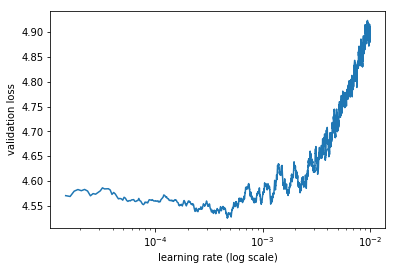

In [66]:
learner.sched.plot()

* Now to train a few epoch of same model:

In [70]:
lr = 0.0005
lrs = lr

In [71]:
learner.fit(lrs, 1, wds=wd, use_clr=(20, 10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                     
    0      4.488005   4.208726   0.279219  
    1      4.38779    4.146933   0.284608                     
    2      4.339405   4.103692   0.288879                     
    3      4.298558   4.075471   0.291703                     
    4      4.260384   4.054879   0.293725                     
    5      4.238347   4.039256   0.295072                     
    6      4.230653   4.028909   0.296314                     
    7      4.207525   4.017993   0.297614                     
    8      4.190072   4.010223   0.298589                     
    9      4.171842   4.001197   0.299301                     
    10     4.179247   3.995295   0.299863                     
    11     4.165434   3.990507   0.300163                     
    12     4.142475   3.985639   0.30096                      
    13     4.136125   3.982005   0.301323                     
    14     4.127443   3.979073   0.301641                     


[array([3.97907]), 0.30164107122502404]

In [73]:
learner.save('lm1')

In [74]:
learner.save_encoder('lm1_enc')

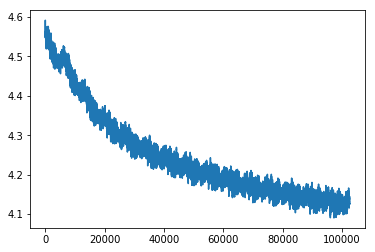

In [77]:
learner.sched.plot_loss()

Note that results are better than Lesson 4's model after the first epoch.

### 00:52:40 - Audience question

* Q1: What is the Wikitext 103 model, is it AUD LSTM again??
* A1: Yes.

## 00:53:09 - Fast.ai doc project

* Trying to build great documentation for Fast.ai project.
  * Uses [AsciiDoc](https://www.methods.co.nz/asciidoc/) which is Markdown but with a lot more features.

## 00:58:36 - Language model vs word2vec

* Word2Vec is simply a word embedding matrix, giving each word a vector, this model includes other pretrained layers (400 dim embedding matrix, 3 hidden layers and 1150 activations per layer).
  * Huge difference in levels of capabilities.

## 01:00:25 - Audience questions

* Q1: What if Numpy array doesn't fit in memory?
* A1: Usually doesn't come up: can fit a lot of ints in memory.

* Q2: What is the idea behind averaging the weights of embeddings for words that aren't in the training corpus?
* A2: Have to set weights to something. Could set to 0 but that's an extreme value. Could set to random: but what would the mean and std be of the numbers?

## 01:02:20 - LanguageModelLoader

* 

### 01:15:?? - Audience questions

* Q1: Does this work on text corpuses for any language. Would you have to retrain?
* A1: It would work but you'd obviously have to train on a big corpus. The pretrained weights would only be suitable for English language.

## 01:16:53 - RNN Encoder

* Standard RNN module based on Stephen Merity's paper [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf)

* BPTT randomisation:
  * Halve the backprop through time 5% of the time.
  * Make the sequence length a normally distributed random number with a std of 5.

In [ ]:
from fastai.core import BasicModel

In [ ]:
class LanguageModel(BasicModel):
    def get_layers_groups(self):
        m = self.model[0]
        return [*zip(m.rnns, m.dropouths), (self.model[1], m.dropouti)]
    
    
class LanguageModelData():
    def __init__(self, path, pad_idx, nt, trn_dl, val_dl, test_dl=None, bptt=70, backwards=False, **kwargs):
        self.path, self.pad_idx, self.nt = path, pad_idx, nt
        self.trn_dl, self.val_dl, self.test_dl = trn_dl, val_dl, test_dl
        
    def get_model(self, opt_fn, emd_sz, n_hid, n_layers, **kwargs):
        m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)
        model = LanguageModel(to_gpu(m))
        return RNN_Learner(self, model, opt_fn=opt_fn)
    

class RNN_Learner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.cross_entropy

In [ ]:
def get_language_model(
    n_tok, emb_sz, nhid, nlayers, pad_token,
    dropout=0.4, dropouth=0.3, dropouti=0.5, dropoute=0.1,
    wdrop=0.5, tie_weights=True
):
    rnn_enc = RNN_Encoder(
        n_tok, emb_sz, nhid=nhid, nlayers=nlayers, pad_token=pad_token,
        dropouth=dropouth, dropouti=dropouti, dropoute=dropoute,
        wdrop=wdrop
    )
    enc = rnn_enc.encoder if tie_weights else None
    return SequentialRNN(
        rnn_enc, LinearDecoder(n_tok, emb_sz, dropout, tie_encoder=enc)
    )
    
def get_rnn_classifier(
    bptt, max_seq, n_class, n_tok, emb_sz,
    n_hid, n_layers, pad_token, layers, drops, bidir=False,
    dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5
):
    rnn_enc = MultiBatchRNN(
        bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token,
        layers, drops, bidir=bidir, dropouth=dropouth,
        dropouti=dropouto, dropoute=dropoute, wdrop=wdrop
    )
    return SequentialRNN(rnn_enc, PoolingLinearClassifier(layers, drop))

In [ ]:
class RNN_Encoder(nn.Module):
    initrange = 0.1
    
    def __init__(self, ntoken, emb_sz, nhid, nlayers, pad_token, bidir=False,)